In [1]:
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

import kagglehub

from constants import dataset_name, opciones, CV, scoring
from utils import cargar_imagenes, evaluar_rendimiento, save_excel_cv

from modelos.RegresionLogistica import regresion_logistica
from modelos.CNN import cnn1, cnn2
from modelos.KNN import knn, knn_with_gridsearch
from modelos.ArbolDeDecision import arbol_decision, arbol_decision_vgg16, arbol_vgg16_pca
from modelos.MobileNetV2 import train_mobilenetv2_model
from modelos.RandomForest import random_forest, rforest_vgg16_pca, rforest_vgg16_pca_hog
from Extractores_con_clasificador.hog_main import main_hog, extract_hog_features
from Extractores_con_clasificador.ann_hog import ann_hog
from Extractores_con_clasificador.svm_hog import svm_hog
from tensorflow.keras.utils import to_categorical
from modelos.MobileNetV2 import train_mobilenetv2_model

import matplotlib.pyplot as plt

# Descargar dataset
path = kagglehub.dataset_download(dataset_name)

# cargar train y test
X_train_rgb, y_train = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="rgb")
X_test_rgb, y_test = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="rgb")
X_train_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="grayscale")
X_test_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="grayscale")
X_train_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), target_size=(64, 64))
X_test_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), target_size=(64, 64))

# Codificar etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

epochs = 100
batch_size = 100
history = []


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## si es regresión logística rgb ##
modelLR_rgb, scoresLR_rgb = regresion_logistica(X_train_rgb, y_train_encoded)
save_excel_cv(scoresLR_rgb, "Regresión Logística RGB")

In [4]:
scores_RF_VGG_PCA_HOG = {'fit_time': [57.03687286, 57.75530291, 58.63800883, 57.5058589 , 57.21213508], 
                         'score_time': [0.18205428, 0.19486666, 0.21000838, 0.17675304, 0.18600368], 
                         'test_accuracy': [0.47175141, 0.50847458, 0.48728814, 0.5       , 0.50282486], 
                         'test_precision': [0.48036714, 0.51298292, 0.49314922, 0.5192612 , 0.51314899], 
                         'test_recall': [0.45286691, 0.49203195, 0.46949149, 0.48030549, 0.48352989], 
                         'test_f1': [0.45306809, 0.49380836, 0.47097024, 0.4810936 , 0.48378187], 
                         'test_roc_auc': [0.7575709 , 0.77457836, 0.77561203, 0.77389724, 0.7855328 ]}
save_excel_cv(scores_RF_VGG_PCA_HOG, "Random forest VGG16 PCA HOG")

{'fit_time': array([243.75289154, 238.94802904, 223.00812745, 309.87033486,
       195.86208987]), 'score_time': array([0.65084386, 0.56014276, 0.59805107, 0.5166657 , 0.53463554]), 'test_accuracy': array([0.37429379, 0.34887006, 0.32627119, 0.37429379, 0.37711864]), 'test_precision': array([0.360911  , 0.34869617, 0.32552323, 0.36698258, 0.37940236]), 'test_recall': array([0.3612659 , 0.34811868, 0.3235971 , 0.35968507, 0.36655325]), 'test_f1': array([0.35879968, 0.34641024, 0.32419283, 0.35815078, 0.36552693]), 'test_roc_auc': array([0.66949605, 0.66420851, 0.64494095, 0.68413902, 0.68129405])}


In [10]:
scores_arbol_VGG = {'fit_time': [2.92314553, 2.79935145, 2.73940516, 2.72962141, 3.13327861], 
 'score_time': [0.01353049, 0.01208973, 0.0129962 , 0.01604486, 0.01669478],
   'test_accuracy': [0.45762712, 0.46327684, 0.45621469, 0.45480226, 0.47175141], 
   'test_precision': [0.45753203, 0.46106483, 0.45660949, 0.45518212, 0.46020465]
   , 'test_recall': [0.4484089 , 0.45764843, 0.4502945 , 0.44352499, 0.45596342],
     'test_f1': [0.44756566, 0.45650768, 0.45091984, 0.44456435, 0.45597603], 
     'test_roc_auc': [0.68809414, 0.69802387, 0.6701636 , 0.68289768, 0.69160653]}
save_excel_cv(scores_arbol_VGG, "Arbol de decisión VGG16")

In [12]:
scores_arbol_VGG_PCA = {'fit_time': [2.0969615 , 2.09246373, 2.24219704, 2.21344399, 2.15724707], 
                        'score_time': [0.01099706, 0.00998712, 0.01115298, 0.01300621, 0.00999522],
                        'test_accuracy': [0.38559322, 0.41384181, 0.40112994, 0.42231638, 0.47175141], 
                        'test_precision': [0.38396418, 0.40914838, 0.39453507, 0.41153651, 0.461122  ],
                        'test_recall': [0.38392835, 0.41108042, 0.39469703, 0.41286745, 0.46034558], 
                        'test_f1': [0.38297892, 0.40828347, 0.39427767, 0.41137591, 0.45996553], 
                        'test_roc_auc': [0.61478894, 0.63208578, 0.62228752, 0.63406091, 0.66379507]}
save_excel_cv(scores_arbol_VGG_PCA, "Arbol de decisión VGG16 PCA")

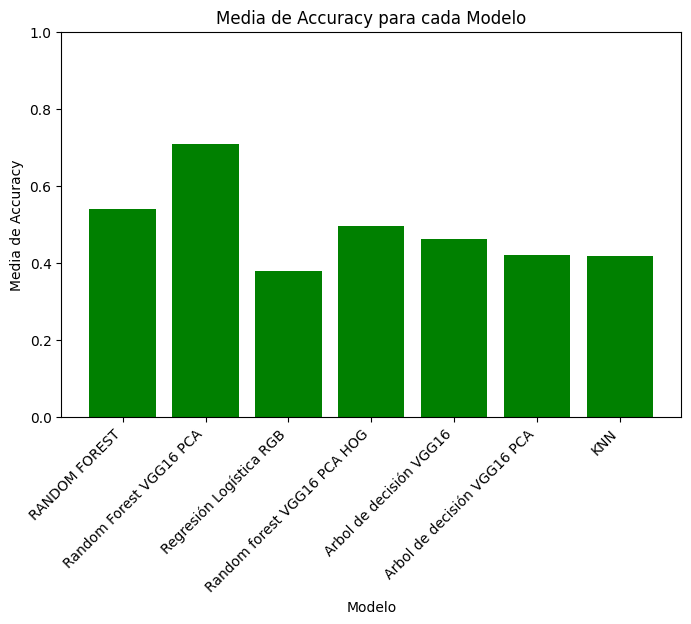

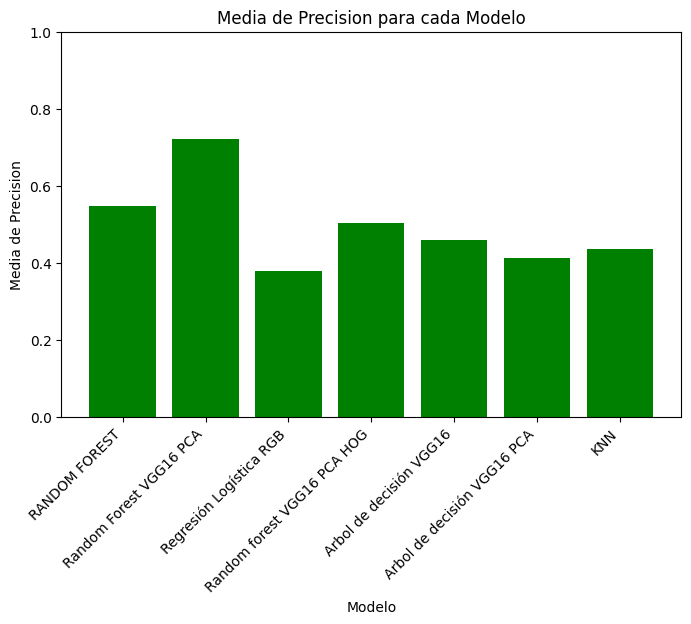

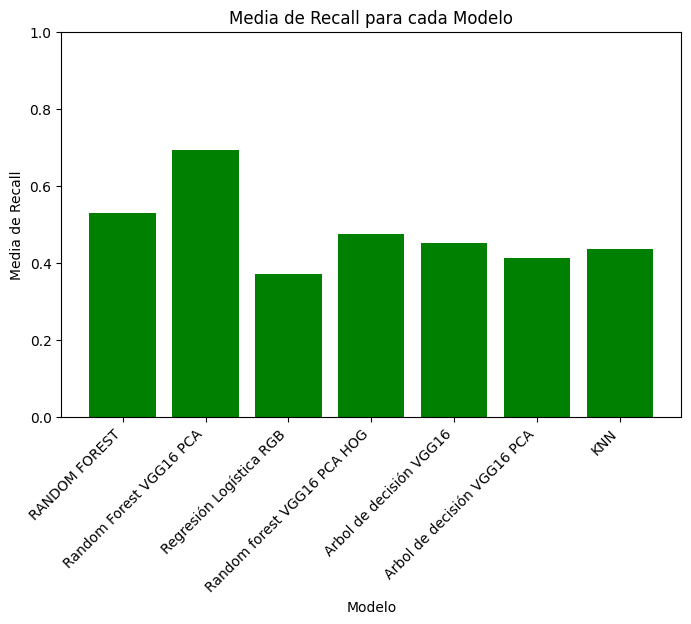

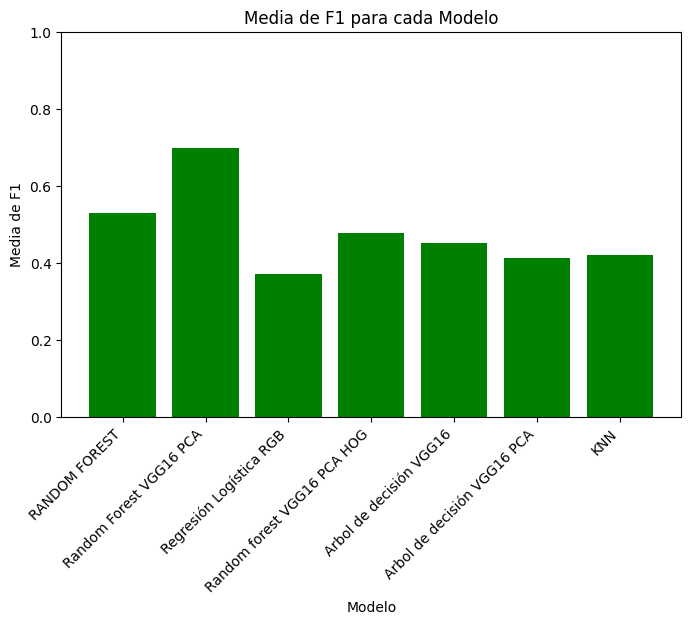

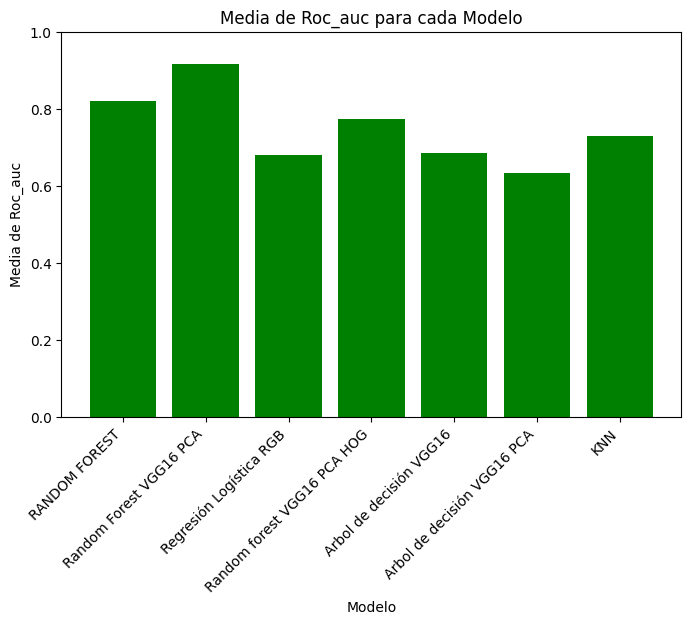

In [16]:
import pandas as pd
def graficar_metrics_desde_excel(file_path):
    # Leer el archivo Excel
    df = pd.read_excel(file_path, index_col=0)

    expected_columns = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    if not all(col in df.columns for col in expected_columns):
        raise ValueError(f"El archivo debe contener las siguientes columnas: {expected_columns}")

    # Extraer los modelos (que están en el índice)
    modelos = df.index
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


    # Graficar la media de cada métrica para cada modelo
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.bar(modelos, df[metric], color='g')
        plt.title(f'Media de {metric.capitalize()} para cada Modelo')
        plt.xlabel('Modelo')
        plt.ylabel(f'Media de {metric.capitalize()}')
        plt.ylim([0, 1])  # Asegurarse de que el rango de la métrica esté entre 0 y 1
        plt.xticks(rotation=45, ha='right')
        plt.show()


graficar_metrics_desde_excel('results_cv.xlsx')


In [2]:
save_excel_cv(scoresLR_rgb, "Regresión Logística RGB")

NameError: name 'scoresLR_rgb' is not defined

In [6]:
## si es regresión logística gray ##
modelLR_gray, scoresLR_gray = regresion_logistica(X_train_gray, y_train_encoded)
save_excel_cv(scoresLR_gray, "Regresión Logística gray")


KeyboardInterrupt: 

In [ ]:
## si es regresión logística gray ##
modelLR_gray, scoresLR_gray = regresion_logistica(X_train_gray, y_train_encoded)
save_excel_cv(scoresLR_gray, "Regresión Logística gray")


In [ ]:
## si es CNN1 ##
model1 = cnn1()
model1.summary()

history.append(model1.fit(X_train_rgb_64, y_train_encoded,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rgb_64, y_test_encoded)))

history.history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,877 (93.27 KB)

 Trainable params: 23,877 (93.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.2500 - loss: 1.5903 - val_accuracy: 0.3800 - val_loss: 1.5105
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.3677 - loss: 1.4486 - val_accuracy: 0.3400 - val_loss: 1.3872
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.3971 - loss: 1.3413 - val_accuracy: 0.3600 - val_loss: 1.3305
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4175 - loss: 1.2966 - val_accuracy: 0.4800 - val_loss: 1.2612
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4527 - loss: 1.2624 - val_accuracy: 0.4600 - val_loss: 1.2378
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.4683 - loss: 1.2587 - val_accuracy: 0.5000 - val_loss: 1.1928
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4943 - loss: 1.2164 - val_accuracy: 0.5000 - val_loss: 1.1920
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4974 - loss: 1.2165 - val_accu

In [ ]:
## si es CNN2 ##    
model2 = cnn2()
model2.summary()

history.append(model2.fit(X_train_rgb_64, y_train_encoded,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_test_rgb_64, y_test_encoded)))

history.history

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,437 (275.14 KB)

 Trainable params: 70,245 (274.39 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.4161 - loss: 1.4247 - val_accuracy: 0.3000 - val_loss: 1.5844
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 553ms/step - accuracy: 0.5689 - loss: 1.0896 - val_accuracy: 0.4200 - val_loss: 1.5080
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 554ms/step - accuracy: 0.6341 - loss: 0.9761 - val_accuracy: 0.4600 - val_loss: 1.4856
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 551ms/step - accuracy: 0.6528 - loss: 0.9130 - val_accuracy: 0.2200 - val_loss: 1.5359
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 556ms/step - accuracy: 0.6766 - loss: 0.8722 - val_accuracy: 0.3000 - val_loss: 1.5017
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 557ms/step - accuracy: 0.6867 - loss: 0.8269 - val_accuracy: 0.3000 - val_loss: 1.4924
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 560ms/step - accuracy: 0.7261 - loss: 0.7307 - val_accuracy: 0.3000 - val_loss: 1.5482
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 560ms/step - accuracy: 0.7003 - loss: 0.7604 - 

In [ ]:

## KNN ## 
_, _, scoresKNN = knn(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded)

save_excel_cv(scoresKNN, "KNN")

TypeError: knn() takes 3 positional arguments but 4 were given

In [14]:
modelKNN, pcaKNN, scoresKNN = knn_with_gridsearch(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded)

Mejores parámetros: {'knn__n_neighbors': 7, 'pca__n_components': 30}
   param_pca__n_components  param_knn__n_neighbors  mean_test_accuracy  \
2                       30                       7            0.435311   
3                       50                       7            0.430226   
0                       30                       3            0.413842   
1                       50                       3            0.412429   

   mean_test_precision  mean_test_recall  mean_test_f1  mean_test_roc_auc  
2             0.436485          0.421142      0.416222           0.728680  
3             0.440036          0.412501      0.406571           0.725369  
0             0.425091          0.403926      0.402425           0.687863  
1             0.424728          0.400201      0.397598           0.686073  


In [ ]:
datos = {
        'precision': [0.435028],
        'recall': [0.435433], 
        'f1': [0.420852 ], 
        'accuracy': [0.416206], 
        'roc_auc': [0.728536]
}
if os.path.exists("results_cv.xlsx"):
    results = pd.read_excel("results_cv.xlsx", index_col=0)
    df = pd.DataFrame(datos, index=["KNN"])
    results = pd.concat([results, df], ignore_index=False)
    results.to_excel("results_cv.xlsx")
else:
    results = pd.DataFrame(datos)
    results.index = ["KNN"]
    results.to_excel("results_cv.xlsx")
 

KeyboardInterrupt: 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Aplanar las imágenes para el Árbol de Decisión
X_train_flat = X_train_rgb_64.reshape(X_train_rgb_64.shape[0], -1)  # De 4D a 2D

param_grid = {
    'max_depth': [10, 20, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'],  # Función de división
}

# Búsqueda de los mejores parámetros utilizando GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5) #Validación cruzada
grid_search.fit(X_train_flat, y_train)

# Obtener el mejor modelo
model_tree = grid_search.best_estimator_
print(grid_search)


In [ ]:
modelTREE_VGG16 = arbol_decision_vgg16(X_train_rgb_64, y_train_encoded)
evaluar_rendimiento(modelTREE_VGG16, X_test_rgb_64, y_test, "Árbol de Decisión VGG16")


In [ ]:
modelTREE_VGG16_PCA = arbol_vgg16_pca(X_train_rgb_64, y_train_encoded)
# Evaluar el modelo con las funciones definidas previamente
evaluar_rendimiento(modelTREE_VGG16_PCA, X_test_rgb_64, y_test, "Árbol de Decisión VGG16 PCA")

In [ ]:
num_classes = len(np.unique(y_train_encoded))  # Asegurar que tenemos el número correcto de clases
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

# Llamada a la función de entrenamiento
model_1 = train_mobilenetv2_model(X_train_rgb, y_train_onehot, X_test_rgb, y_test_onehot, epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001)
model_2 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3), epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001)
model_3 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3),epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.0001)
model_4 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3),epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.3, learning_rate=0.001)

d:\Documentos\Master Informatica Industrial y Robotica\VA I\Trabajo_git\clasificacion-supervisada\modelos\MobileNetV2.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 95s 771ms/step - accuracy: 0.7031 - loss: 0.8184 - val_accuracy: 0.8000 - val_loss: 0.7273
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 747ms/step - accuracy: 0.9016 - loss: 0.2687 - val_accuracy: 0.7600 - val_loss: 0.7518
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 79s 712ms/step - accuracy: 0.9156 - loss: 0.2395 - val_accuracy: 0.8200 - val_loss: 0.7202
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 77s 696ms/step - accuracy: 0.9380 - loss: 0.1680 - val_accuracy: 0.7800 - val_loss: 0.8725
Epoch 5/10
 79/111 ━━━━━━━━━━━━━━━━━━━━ 22s 714ms/step - accuracy: 0.9434 - loss: 0.1593

KeyboardInterrupt: 

In [8]:
modelRF, scoresRF = random_forest(X_train_rgb_64, y_train, X_test_rgb_64)


In [11]:
save_excel_cv(scoresRF, "RANDOM FOREST")

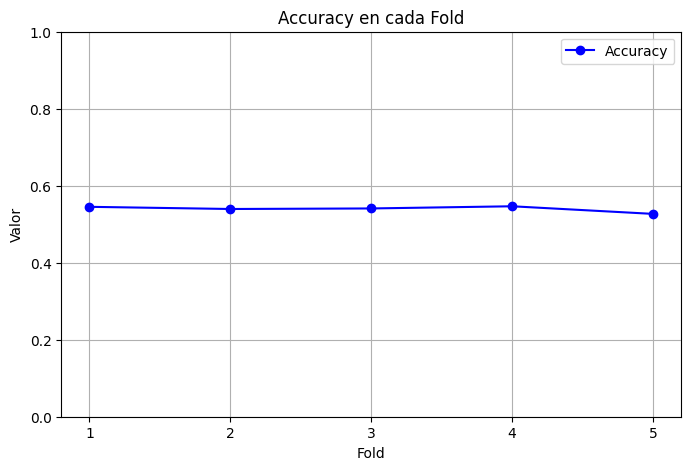

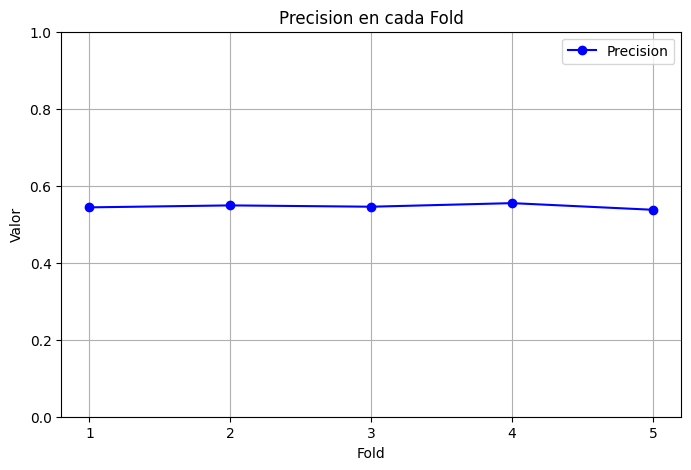

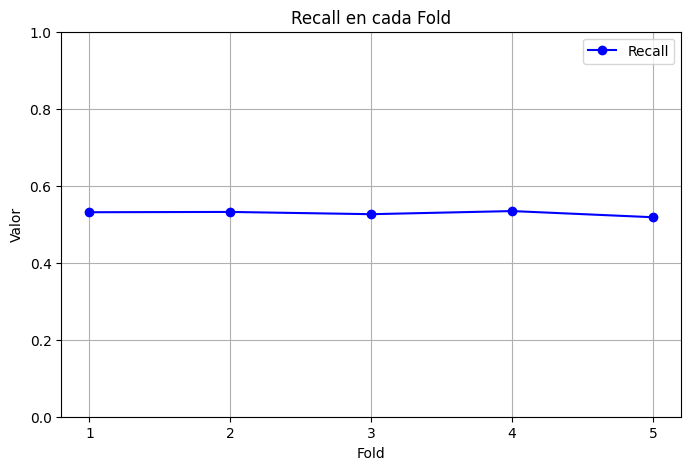

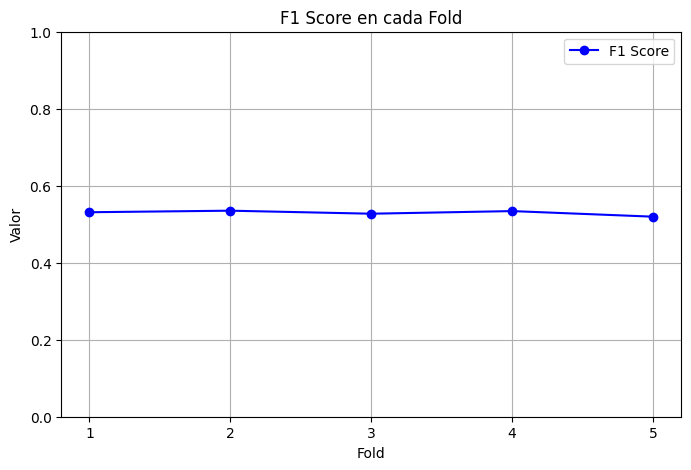

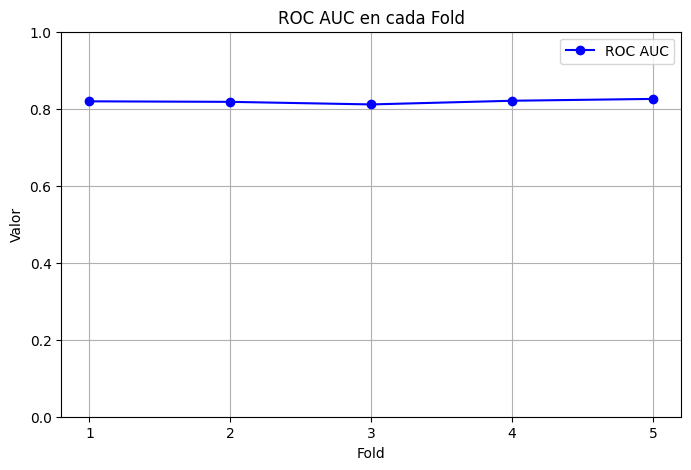

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Extraer las métricas del diccionario 'scoresLR'
accuracy = scoresRF['test_accuracy']
precision = scoresRF['test_precision']
recall = scoresRF['test_recall']
f1 = scoresRF['test_f1']
roc_auc = scoresRF['test_roc_auc']

# Definir las métricas y sus nombres
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}


for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(metric_values) + 1), metric_values, marker='o', color='b', label=metric_name)
    plt.title(f'{metric_name} en cada Fold')
    plt.xlabel('Fold')
    plt.ylabel('Valor')
    plt.xticks(np.arange(1, len(metric_values) + 1))
    plt.ylim([0, 1])  # Asegurar que todas las métricas estén en el rango de 0 a 1
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
modelRF_VGG16, scoresRF_VGG16 = rforest_vgg16_pca(X_train_rgb, y_train, X_test_rgb)        


111/111 ━━━━━━━━━━━━━━━━━━━━ 559s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


In [18]:
from constants import excel_filename_cv
import pandas as pd
def save_excel_cv(scores): 
    datos = {
        'precision': [np.mean(scores['test_precision'])],
        'recall': [np.mean(scores['test_recall'])], 
        'f1': [np.mean(scores['test_f1'])], 
        'accuracy': [np.mean(scores['test_accuracy'])], 
        'roc_auc': [np.mean(scores['test_roc_auc'])]
    }
    if os.path.exists(excel_filename_cv):
        results = pd.read_excel(excel_filename_cv, index_col=0)
        df = pd.DataFrame(datos, index=['Random Forest VGG16 PCA'])
        results = pd.concat([results, df], ignore_index=False)
        results.to_excel(excel_filename_cv)

111/111 ━━━━━━━━━━━━━━━━━━━━ 687s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


In [ ]:
modelRF_VGG16_PCA = rforest_vgg16_pca_hog(X_train_rgb_64, y_train, X_test_rgb_64)

In [ ]:
from skimage.feature import hog
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
from Extractores_con_clasificador.ann_hog import ann_hog
from Extractores_con_clasificador.svm_hog import svm_hog
from sklearn.svm import SVC

def ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes):
    # Convertir las etiquetas a one-hot encoding
    y_train_onehot = to_categorical(y_train, num_classes)
    y_test_onehot = to_categorical(y_test, num_classes)

    # Crear el modelo ANN
    ann_model = Sequential([
        Dense(512, activation='relu', input_dim=X_train_hog.shape[1]),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # num_classes = cantidad de clases
    ])

    # Compilar el modelo
    ann_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo ANN
    ann_model.fit(X_train_hog, y_train_onehot, epochs=5, batch_size=32, validation_data=(X_test_hog, y_test_onehot))

    # Obtener predicciones
    y_pred_ann = ann_model.predict(X_test_hog)
    y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)

    # Calcular precisión
    accuracy_ann = accuracy_score(y_test, y_pred_ann_classes)
    print(f"Precisión ANN con HOG: {accuracy_ann:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de ANN con HOG:")
    print(classification_report(y_test, y_pred_ann_classes))

    return ann_model

def svm_hog(X_train_hog, y_train, X_test_hog, y_test):
    # Crear y entrenar el clasificador SVM
    svm_model = SVC(kernel="linear", random_state=42)
    svm_model.fit(X_train_hog, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred_svm = svm_model.predict(X_test_hog)

    # Evaluar precisión
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"Precisión SVM con HOG: {accuracy_svm:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de SVM con HOG:")
    print(classification_report(y_test, y_pred_svm))

    return svm_model

def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

def main_hog(X_train, X_test, y_train, y_test, num_classes):
    # Extraer características HOG
    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    # Entrenar y evaluar ANN con características HOG
    print("Entrenando y evaluando ANN con características HOG...")
    ann_model = ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes)

    # Entrenar y evaluar SVM con características HOG
    print("\nEntrenando y evaluando SVM con características HOG...")
    svm_model = svm_hog(X_train_hog, y_train, X_test_hog, y_test)

    return ann_model, svm_model

In [ ]:
print(type(hog))  # Debe imprimir: <class 'function'>


<class 'function'>


In [ ]:
num_classes = len(np.unique(y_train))  # Suponiendo que y_train contiene las etiquetas
main_hog(X_train_gray, X_test_gray, y_train_encoded, y_test_encoded, num_classes)

Entrenando y evaluando ANN con características HOG...


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2620 - loss: 2.2188 - val_accuracy: 0.3400 - val_loss: 1.5087
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3629 - loss: 1.4627 - val_accuracy: 0.3200 - val_loss: 1.5507
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3891 - loss: 1.4153 - val_accuracy: 0.2600 - val_loss: 1.5111
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4106 - loss: 1.3725 - val_accuracy: 0.3600 - val_loss: 1.4657
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4087 - loss: 1.3856 - val_accuracy: 0.3400 - val_loss: 1.4608
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Precisión ANN con HOG: 0.34

Reporte de ANN con HOG:
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.33      0.40      0.36        10
           2       0.31      0.40      0.35        10
           3       0.33      0.10      0.15        1

(<Sequential name=sequential, built=True>,
 SVC(kernel='linear', random_state=42))

In [ ]:
## diagrama de cajas validación cru
data = [scoresLR_rgb['test_accuracy'], scoresLR_gray['test_accuracy'], scoresKNN['test_accuracy']]
_, ax = plt.subplots()
ax.set_title('Modelos')
ax.boxplot(data,labels=['LR_RGB','LR_GRAY','KNN'])

NameError: name 'scoresLR_rgb' is not defined

In [ ]:
if os.path.exists(excel_filename):
    results = pd.read_excel(excel_filename_cv, index_col=0)